In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
import pandas as pd
sys.path.append('../spock/')
from modelfitting import ROC_curve
from sklearn.metrics import roc_curve, auc 
from sklearn import metrics


try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

# Resonant

In [12]:
df = pd.read_csv('../training_data/combinedresonant/additional_featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col=0)
df.head()

,EMfracstdnear,EPstdnear,AMDcritnear,AMDtriofracnear,EMcrossnear,MMRstrengthnear,jnear,knear,EMfracstdfar,EPstdfar,...,AMDtriofracfar,EMcrossfar,MMRstrengthfar,jfar,kfar,MEGNO,MEGNOstd,stableinshortintegration,betanear,betafar
0,0.030049,0.000283,3.184811e-09,27.377330,0.060234,0.491521,12.0,1.0,0.000883,0.000330,...,0.042849,0.504063,NaN,NaN,NaN,2.005520,0.224927,1.0,2.581870,19.828024
1,0.017244,0.000138,1.333975e-08,2.207906,0.080547,0.427847,9.0,1.0,0.008929,0.002141,...,0.786883,0.240504,0.008172,4.0,1.0,2.004079,0.223456,1.0,3.102609,9.349653
2,0.028790,0.000989,9.468202e-09,32.219738,0.129660,1.007448,6.0,1.0,0.000513,0.000936,...,0.005277,1.001981,0.010448,3.0,2.0,2.004640,0.223848,1.0,4.072226,19.851676
3,0.038118,0.000942,2.009257e-06,0.949464,0.406112,0.350829,5.0,2.0,0.035023,0.003593,...,0.692484,0.427768,0.012785,5.0,2.0,2.006904,0.223015,1.0,10.746532,15.024486
4,0.026085,0.001920,6.321091e-09,5.948807,0.059897,0.290810,12.0,1.0,0.052336,0.001385,...,0.242176,0.257596,0.033091,7.0,2.0,2.083530,0.225772,1.0,3.700114,7.123620


SPOCK 0.9549879272492006
SPOCK thresh = 0.652 TPR = 0.863 FPR = 0.100


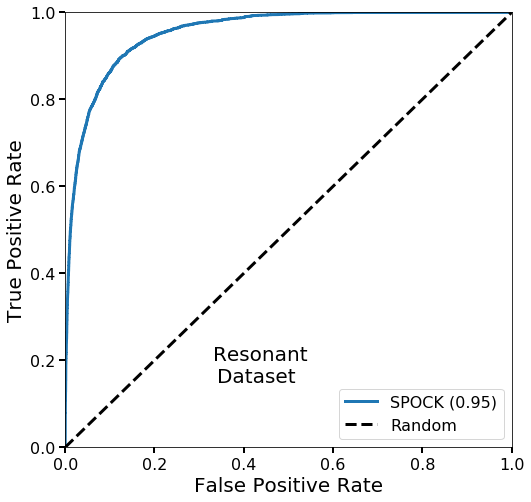

In [15]:
from xgboost.sklearn import XGBClassifier

models = {'SPOCK':'spock'}
#models = {'N-body':'nbody', 'SPOCK':'spock', 'MEGNO':'megno', 'AMD':'AMD', 'Hill':'hill'}
testing_dataset = 'resonant'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

FPRthresh = 0.1

for name, filename in models.items():
    model = XGBClassifier()
    model.load_model('../spock/models/'+filename+'.json')
    testingdatafolder = '../training_data/combinedresonant/featuresNorbits10000.0Nout80trio/'
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model)
    print(name, roc_auc)
    threshindex = np.where(fpr > FPRthresh)[0][0]
    print(name, "thresh = {0:.3f}".format(ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]))
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.text(0.33, 0.2, "Resonant", fontsize=20)
ax.text(0.34, 0.15, "Dataset", fontsize=20)
ax.legend()

SPOCK AUC = 0.9938 Thresh = 0.274 TPR = 0.986 FPR = 0.100
MEGNO AUC = 0.8696 Thresh = 0.967 TPR = 0.497 FPR = 0.102


KeyError: "None of [Index(['betanear', 'betafar'], dtype='object')] are in the [columns]"

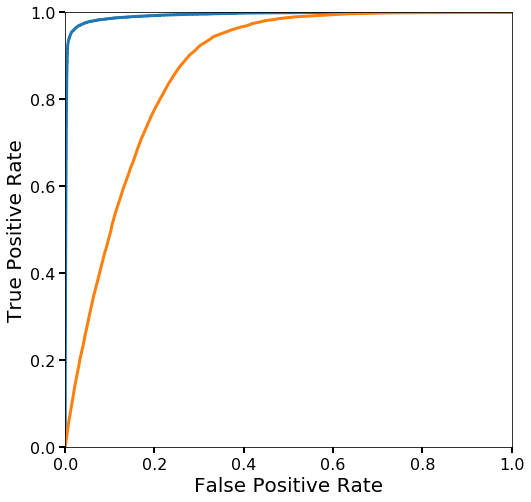

In [14]:
from xgboost.sklearn import XGBClassifier

models = {'SPOCK':'spock', 'MEGNO':'megno', 'Hill':'hill'}
featuresdic = {'SPOCK':None, 'MEGNO':['MEGNO'], 'Hill':['betanear', 'betafar']}
testing_dataset = 'resonant'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

FPRthresh = 0.1
thresh=0.1

for name, filename in models.items():
    model = XGBClassifier()
    model.load_model('../spock/models/'+filename+'.json')
    testingdatafolder = '../training_data/combinedresonant/featuresNorbits10000.0Nout80trio/'
    dataset = pd.read_csv(testingdatafolder+"trainingdata.csv", index_col = 0)
    labels = pd.read_csv(testingdatafolder+"labels.csv", index_col=0)
    y = labels['Stable']
    
    features = featuresdic[name]
    if features is None:
        features = dataset.columns.values
    X = dataset[features]
    preds = model.predict_proba(X)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    threshindex = np.where(fpr > thresh)[0][0]
    print(name, "AUC = {0:.4f} Thresh = {1:.3f}".format(roc_auc, ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]))
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))
    
ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.text(0.33, 0.2, "Resonant", fontsize=20)
ax.text(0.34, 0.15, "Dataset", fontsize=20)
ax.legend()

N-body 0.9893085051797815
SPOCK 0.9338657754342667
MEGNO 0.8537492446019923
AMD 0.7312126022558687
Hill 0.7032226514248359


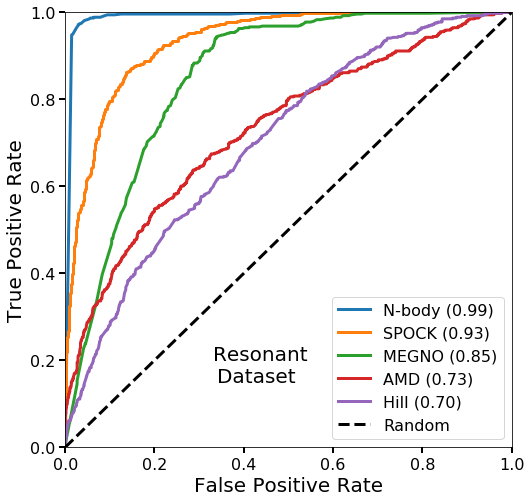

In [20]:
models = {'N-body':'nbody', 'SPOCK':'spock', 'MEGNO':'megno', 'AMD':'AMD', 'Hill':'hill'}
testing_dataset = 'resonant'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')


for name, filename in models.items():
    model, features, featureargs, featurefolder = dill.load(open('../models/'+filename+'.pkl', "rb"))
    testingdatafolder = '../training_data/resonant/'+featurefolder
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features)
    print(name, roc_auc)
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.text(0.33, 0.2, "Resonant", fontsize=20)
ax.text(0.34, 0.15, "Dataset", fontsize=20)
ax.legend()
fig.savefig('resperformance.pdf', bbox_inches='tight')

In [21]:
FPRthresh = 0.1

for name, filename in models.items():
    model, features, featureargs, featurefolder = dill.load(open('../models/'+filename+'.pkl', "rb"))
    testingdatafolder = '../training_data/resonant/'+featurefolder
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features)
    threshindex = np.where(fpr > FPRthresh)[0][0]
    print(name, "thresh = {0:.3f}".format(ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]))

N-body thresh = 0.250 TPR = 0.994 FPR = 0.103
SPOCK thresh = 0.796 TPR = 0.797 FPR = 0.104
MEGNO thresh = 0.983 TPR = 0.464 FPR = 0.103
AMD thresh = 0.928 TPR = 0.375 FPR = 0.100
Hill thresh = 0.909 TPR = 0.281 FPR = 0.101


In [22]:
TPRthresh = 0.9

for name, filename in models.items():
    model, features, featureargs, featurefolder = dill.load(open('../models/'+filename+'.pkl', "rb"))
    testingdatafolder = '../training_data/resonant/'+featurefolder
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features)
    threshindex = np.where(tpr > TPRthresh)[0][0]
    print(name, "thresh = {0:.3f}".format(ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]))

N-body thresh = 0.995 TPR = 0.948 FPR = 0.014
SPOCK thresh = 0.384 TPR = 0.900 FPR = 0.197
MEGNO thresh = 0.936 TPR = 0.900 FPR = 0.307
AMD thresh = 0.687 TPR = 0.900 FPR = 0.722
Hill thresh = 0.692 TPR = 0.902 FPR = 0.670
